# How to get your RAG application to return sources

Often in [Q&A](/docs/concepts/rag/) applications it's important to show users the sources that were used to generate the answer. The simplest way to do this is for the chain to return the Documents that were retrieved in each generation.

We'll work off of the Q&A app we built over the [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post by Lilian Weng in the [RAG tutorial](/docs/tutorials/rag).

We will cover two approaches:

1. Using the basic RAG chain covered in [Part 1](/docs/tutorials/rag) of the RAG tutorial;
2. Using a conversational RAG chain as convered in [Part 2](/docs/tutorials/qa_chat_history) of the tutorial.

We will also show how to structure sources into the model response, such that a model can report what specific sources it used in generating its answer.

## Setup

### Dependencies

We'll use the following packages:

In [1]:
%pip install --upgrade --quiet langchain langchain-community langchainhub beautifulsoup4

### LangSmith

Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls. As these applications get more and more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent. The best way to do this is with [LangSmith](https://smith.langchain.com).

Note that LangSmith is not needed, but it is helpful. If you do want to use LangSmith, after you sign up at the link above, make sure to set your environment variables to start logging traces:

```python
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
```

### Components

We will need to select three components from LangChain's suite of integrations.

A [chat model](/docs/integrations/chat/):

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />

In [2]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

An [embedding model](/docs/integrations/text_embedding/):

import EmbeddingTabs from "@theme/EmbeddingTabs";

<EmbeddingTabs/>

In [3]:
# | output: false
# | echo: false

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

And a [vector store](/docs/integrations/vectorstores/):

import VectorStoreTabs from "@theme/VectorStoreTabs";

<VectorStoreTabs/>

In [4]:
# | output: false
# | echo: false

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## RAG application

Let's reconstruct the Q&A app with sources we built over the [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post by Lilian Weng in the [RAG tutorial](/docs/tutorials/rag).

First we index our documents:

In [6]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [7]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

Next we build the application:

In [8]:
from langchain import hub
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

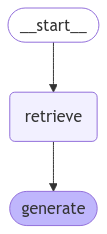

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Because we're tracking the retrieved context in our application's state, it is accessible after invoking the application:

In [10]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='c8471b37-07d8-4d51-856e-4b2c22bca88d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='acb7eb6f-f252-4353-aec2-f459135354ba', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibiliti

Here, `"context"` contains the sources that the LLM used in generating the response in `"answer"`.

## Structure sources in model response

Up to this point, we've simply propagated the documents returned from the retrieval step through to the final response. But this may not illustrate what subset of information the model relied on when generating its answer. Below, we show how to structure sources into the model response, allowing the model to report what specific context it relied on for its answer.

It is straightforward to extend the above LangGraph implementation. Below, we make a simple change: we use the model's tool-calling features to generate [structured output](/docs/how_to/structured_output/), consisting of an answer and list of sources. The schema for the response is represented in the `AnswerWithSources` TypedDict, below.

In [11]:
from typing import List

from typing_extensions import Annotated, TypedDict


# Desired schema for response
class AnswerWithSources(TypedDict):
    """An answer to the question, with sources."""

    answer: str
    sources: Annotated[
        List[str],
        ...,
        "List of sources (author + year) used to answer the question",
    ]


class State(TypedDict):
    question: str
    context: List[Document]
    # highlight-next-line
    answer: AnswerWithSources


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    # highlight-start
    structured_llm = llm.with_structured_output(AnswerWithSources)
    response = structured_llm.invoke(messages)
    # highlight-end
    return {"answer": response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [13]:
import json

result = graph.invoke({"question": "What is Chain of Thought?"})
print(json.dumps(result["answer"], indent=2))

{
  "answer": "Chain of Thought (CoT) is a prompting technique that enhances model performance by instructing it to think step by step, allowing the decomposition of complex tasks into smaller, manageable steps. This method not only aids in task execution but also provides insights into the model's reasoning process. CoT has become a standard approach in improving how language models handle intricate problem-solving tasks.",
  "sources": [
    "Wei et al. 2022"
  ]
}


:::tip

View [LangSmith trace](https://smith.langchain.com/public/51d543f7-bdf6-4d93-9ecd-2fc09bf6d666/r).

:::

## Conversational RAG

[Part 2](/docs/tutorials/qa_chat_history) of the RAG tutorial implements a different architecture, in which steps in the RAG flow are represented via successive [message](/docs/concepts/messages/) objects. This leverages additional [tool-calling](/docs/concepts/tool_calling/) features of chat models, and more naturally accommodates a "back-and-forth" conversational user experience.

In that tutorial (and below), we propagate the retrieved documents as [artifacts](/docs/how_to/tool_artifacts/) on the tool messages. That makes it easy to pluck out the retrieved documents. Below, we add them as an additional key in the state, for convenience.

Note that we define the response format of the tool as `"content_and_artifact"`:

In [14]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

We can now build and compile the exact same application as in [Part 2](/docs/tutorials/qa_chat_history) of the RAG tutorial, with two changes:

1. We add a `context` key of the state to store retrieved documents;
2. In the `generate` step, we pluck out the retrieved documents and populate them in the state.

These changes are highlighted below.

In [15]:
from langchain_core.messages import SystemMessage
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition


class State(MessagesState):
    # highlight-next-line
    context: List[Document]


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: State):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    context = []
    # highlight-start
    for tool_message in tool_messages:
        context.extend(tool_message.artifact)
    # highlight-end
    return {"messages": [response], "context": context}

We can compile the application as before:

In [16]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

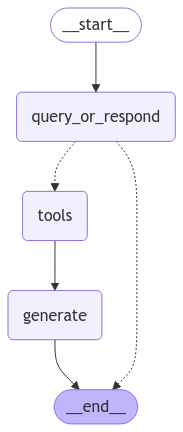

In [17]:
display(Image(graph.get_graph().draw_mermaid_png()))

Invoking our application, we see that the retrieved [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) objects are accessible from the application state.

In [18]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_oA0XZ5hF70X0oW4ccNUFCFxX)
 Call ID: call_oA0XZ5hF70X0oW4ccNUFCFxX
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms b

In [19]:
step["context"]

[Document(id='c8471b37-07d8-4d51-856e-4b2c22bca88d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'),
 Document(id='acb7eb6f-f252-4353-aec2-f459135354ba', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at ea

:::tip

Check out the [LangSmith trace](https://smith.langchain.com/public/cc25515d-2e46-44fa-8bb2-b9cb0f451504/r).

:::